# SETUP

## Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from models.LigandModel import CHEMFEATURE

import umap
from sklearn.cluster import KMeans


## Loading

### Model loading

In [2]:
# No need to run this cell and run the model, the embeddings are loaded after
#device = 'cuda'
#model = CHEMFEATURE(device)

### Data Loading

In [3]:
# Load full dataset
best_ligands_df = pd.read_csv('../data/best_ligands_old.csv') # dataframe with best ligand for each selected protein

# Filter the unique smiles while keeping the index for later use
unique_smiles_df = pd.DataFrame({'Ligand SMILES': best_ligands_df['Ligand SMILES'].unique()})
unique_smiles_df['index'] = unique_smiles_df['Ligand SMILES'].apply(lambda x: best_ligands_df.index[best_ligands_df['Ligand SMILES'] == x].tolist())
unique_smiles_df['Ligand SMILES'] = unique_smiles_df['Ligand SMILES'].apply(lambda x: x[:512]) # the model can only take max 512 letters long smiles. Truncation.

Dataframes:
- best_ligand_df: SMILES of Best ligand to protein.
- unique_smiles_df: unique SMILES (truncated if above 512) and index in the original df --> input of the embedder

# MODEL

## Ligand embedding creation

In [77]:
run = False # No need to run, just load the embeddings that I computed on Colab
if run:
    embeddings = model.get_representations(unique_smiles_df['Ligand SMILES'])
else:
    embeddings = np.load('../data/embeddings_array_old.npy')
    embeddings = pd.read_csv('../data/all_graph_embeddings.csv')


## DIMENSIONALITY REDUCTION

### UMAP

In [78]:

# Normalize the features
X_normalized = StandardScaler().fit_transform(embeddings)

# Apply UMAP
n = 3
umap_model = umap.UMAP(n_components=n,random_state=42)
X_transformed_UMAP = umap_model.fit_transform(X_normalized)

# Create dataframe for UMAP values
umap_df = pd.DataFrame(X_transformed_UMAP, columns=[f'UMAP {i}' for i in range(1, n+1)])

# Merge it with the SMILEs dataframe
merged_umap_df = pd.concat([unique_smiles_df, umap_df], axis=1)

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


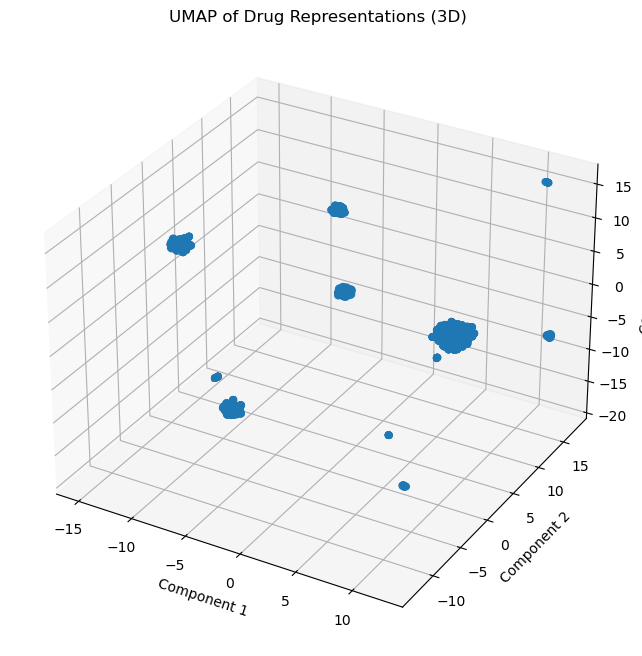

In [79]:
# Plot 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(merged_umap_df['UMAP 1'], merged_umap_df['UMAP 2'], merged_umap_df['UMAP 3'])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('UMAP of Drug Representations (3D)')
plt.show()

From this plot we see that our ligand can be clustered in approximately 9 clusters. We can use KMeans with n_clusters = 8 to fit them and quickly get labels for each cluster. (FYI to be deleted, when I put 10 or 11 it does something strange in the big cluster like it splits it in 2)

## CLUSTERING

### K-MEANS

In [80]:
kmeans_labels_UMAP = KMeans(n_clusters=9, random_state=42).fit_predict(X_transformed_UMAP)
merged_umap_df = pd.concat([merged_umap_df, pd.DataFrame({'class':kmeans_labels_UMAP})], axis=1)

merged_umap_df.sample(5)

,Ligand SMILES,index,UMAP 1,UMAP 2,UMAP 3,class
3737,CC1(C)CCC(C)(C)c2cc(ccc12)-c1ccc([nH]1)-c1ccc(...,[4339],10.336795,-0.123847,4.853446,0
3214,Clc1ccc(CCC(=O)C(=O)NCCc2ccccc2)cc1Cl,[3691],-6.986090,15.266130,-8.369832,3
1210,CCCCCCCCCCOc1ccc(OCC(=O)COc2ccc(cc2)C(O)=O)cc1,[1360],10.384321,-0.500287,3.847215,0
2178,ONC(=O)CCCNC(=O)C(Cc1ccc(O)c(Br)c1)N=O,[2471],-3.344500,7.882205,11.588872,4
3401,Cc1cc(Cl)cc2c(cc(nc12)-c1ccc(Br)cc1)C(O)=O,[3913],-14.302512,0.965878,6.108276,1


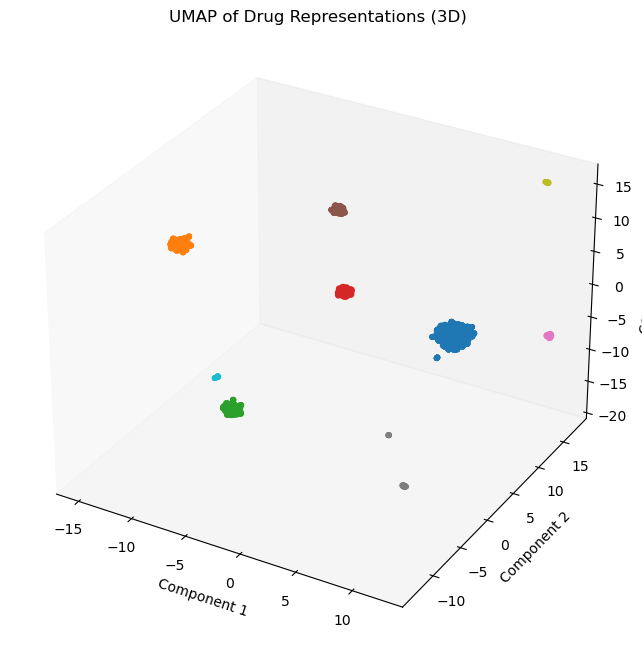

In [81]:
# Plot 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(merged_umap_df['UMAP 1'], merged_umap_df['UMAP 2'], merged_umap_df['UMAP 3'], c=kmeans_labels_UMAP, s=10, cmap ='tab10')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('UMAP of Drug Representations (3D)')
ax.grid(False)  # Remove the grid
plt.show()

# Cluster exploration

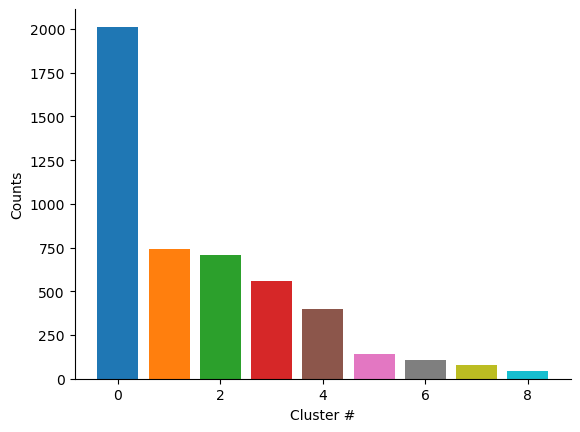

In [84]:
# Check the cluster count to see imbalances in clusters and potential sub families
clusters = np.unique(kmeans_labels_UMAP)
counts = []

for cluster in clusters:
    counts.append(np.where(kmeans_labels_UMAP == cluster)[0].shape[0])

# Plot the bar chart with colors from 'tab10' palette
colors = plt.cm.tab10(clusters / max(clusters))

plt.bar(clusters, counts, color=colors)
plt.xlabel('Cluster #')
plt.ylabel('Counts')
sns.despine()
plt.show()

We see a big number fitting in class 0 and then balanced clusters. Let's check if class 0 can be further subdivided into 2 clusters.

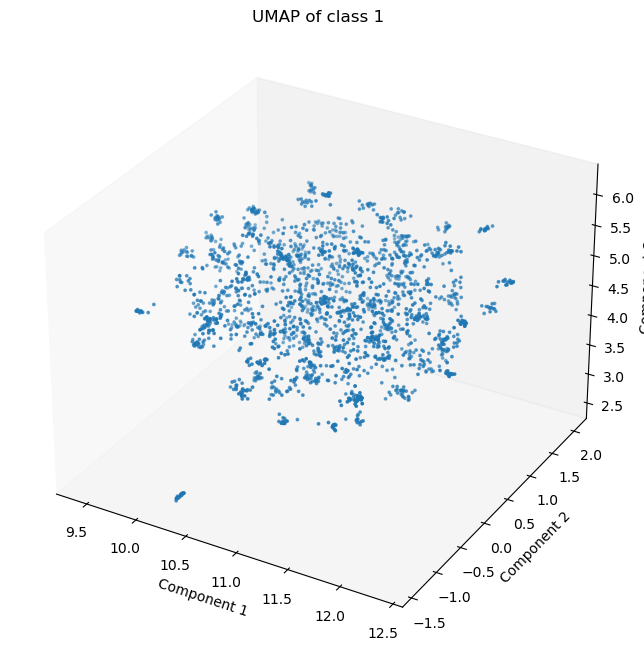

In [85]:
classe1 = merged_umap_df.iloc[np.where(kmeans_labels_UMAP == 0)[0]]

# Plot 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(classe1['UMAP 1'], classe1['UMAP 2'], classe1['UMAP 3'], s=3)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('UMAP of class 1')
ax.grid(False)  # Remove the grid
plt.show()

We see quite a bit of very small clusters that could be use to further subdivide this class. Before doing so, we need to check that the clusters are indeed biologically relevant.

Thus, the next check is to investigate how relevant these clusters are. For this, we will start by analyzing if the clusters are just by SMILES length.

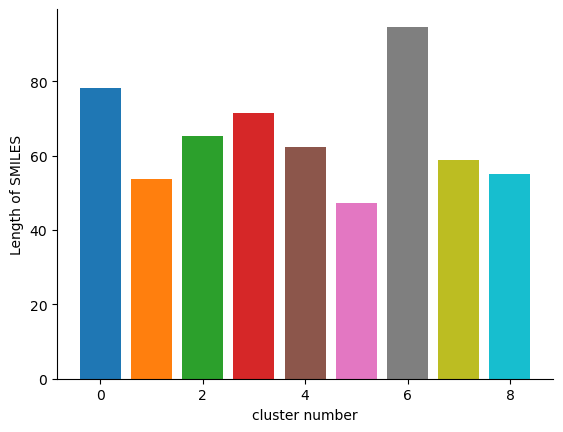

In [147]:
# Step 1: Calculate the average length of SMILES for each class
average_smiles_length = merged_umap_df.groupby('class')['Ligand SMILES'].apply(lambda x: x.str.len().mean())
plt.bar(average_smiles_length.index,average_smiles_length.values, color =colors)
plt.ylabel('Length of SMILES')
plt.xlabel('cluster number')
sns.despine()

We see that there is no difference in the length of the SMILES. The clusters have to be done according to something more complexe than just the length.

Thus, we can look into the small clusters (quicker to assess patterns and check ligands compared to the biggest cluster) and manually inspect similarity. One way to assess similarity is to assess taxonomy using [Classyfire](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0174-y), a web-based application for automated structural classification of chemical entities that can give us taxonomy information.

Let's take for exmaple 20 samples from class 1,2 and 3, we manually insert them in the website and get the following information.

In [148]:
'''smiles_class1 = merged_umap_df.loc[merged_umap_df['class'] == 1]['Ligand SMILES'].sample(20)
smiles_class1.to_csv('../../smiles_class1.csv',index= False) # outside of git repo
smiles_class2 =  merged_umap_df.loc[merged_umap_df['class'] == 2]['Ligand SMILES'].sample(20)
smiles_class2.to_csv('../../smiles_class2.csv',index= False)
smiles_class3 =  merged_umap_df.loc[merged_umap_df['class'] == 3]['Ligand SMILES'].sample(20)
smiles_class3.to_csv('../../smiles_class3.csv',index= False)'''

Here we manually modified these csv by adding the classification outputted by the classyfire.

In [159]:
smiles_class3 = pd.read_csv('../../smiles_class3.csv',delimiter = ';')
smiles_class2 = pd.read_csv('../../smiles_class2.csv',delimiter = ';')
smiles_class1 = pd.read_csv('../../smiles_class1.csv',delimiter = ';')

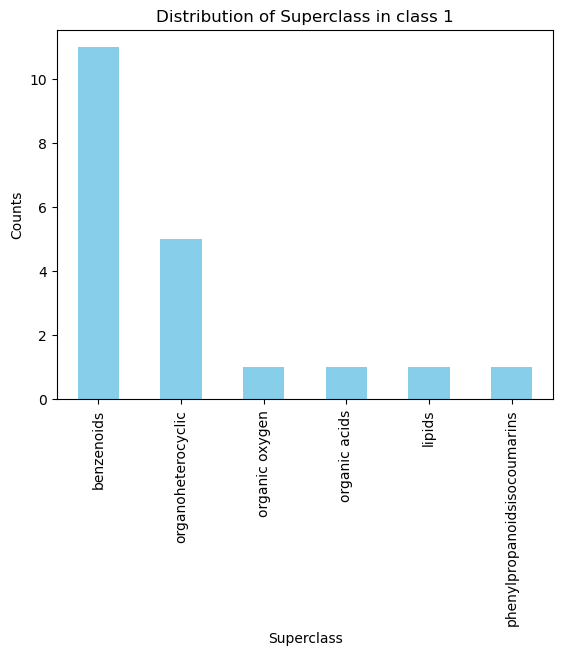

In [160]:
smiles_class1['Superclass'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Superclass')
plt.ylabel('Counts')
plt.title('Distribution of Superclass in class 1')
plt.show()

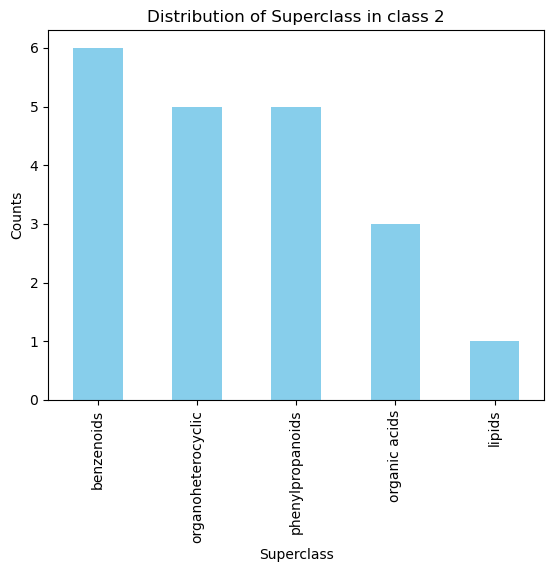

In [161]:
smiles_class2['Superclass'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Superclass')
plt.ylabel('Counts')
plt.title('Distribution of Superclass in class 2')
plt.show()

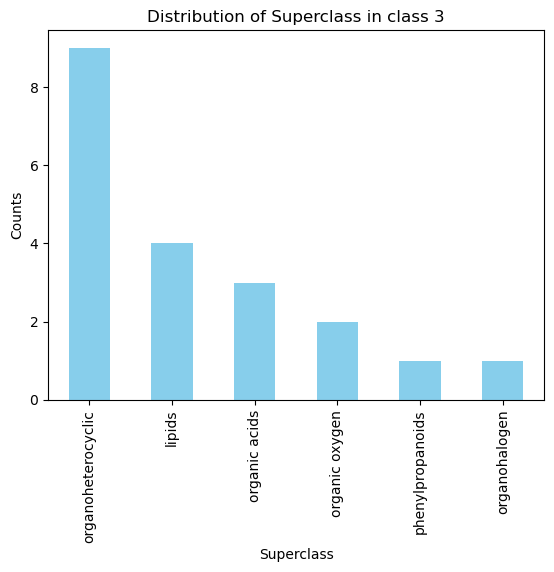

In [162]:
smiles_class3['Superclass'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Superclass')
plt.ylabel('Counts')
plt.title('Distribution of Superclass in class 3')
plt.show()

Due to lack of time it is not possible to generate more data to validate the clusters, but from a first manipulation it seems that the clusters may be representing different Superclass as called by Classyfire. The purpose of this analysis was to show that the clusters were biologically meaningful, which our analysis relies on. Our analysis will not rely on the classification labels from Classyfire, thus this will not be pushed further.